In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')
import jax
jax.config.update('jax_platform_name', 'cpu')

import glob
import argparse
import pickle
# from vbd.data.data_utils import *
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map  # or thread_map

from waymax import dataloader
from waymax.config import DataFormat
import functools
import numpy as np
from vbd.model.model_utils import inverse_kinematics

import torch

/opt/conda/envs/vbd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TrajectoryType:
    STATIONARY = 0
    STRAIGHT = 1
    STRAIGHT_RIGHT = 2
    STRAIGHT_LEFT = 3
    RIGHT_U_TURN = 4
    RIGHT_TURN = 5
    LEFT_U_TURN = 6
    LEFT_TURN = 7


def classify_track(start_point, end_point, start_velocity, end_velocity, start_heading, end_heading):
    # The classification strategy is taken from
    # waymo_open_dataset/metrics/motion_metrics_utils.cc#L28

    # Parameters for classification, taken from WOD
    kMaxSpeedForStationary = 2.0  # (m/s)
    kMaxDisplacementForStationary = 5.0  # (m)
    kMaxLateralDisplacementForStraight = 5.0  # (m)
    kMinLongitudinalDisplacementForUTurn = -5.0  # (m)
    kMaxAbsHeadingDiffForStraight = np.pi / 6.0  # (rad)

    x_delta = end_point[0] - start_point[0]
    y_delta = end_point[1] - start_point[1]

    final_displacement = np.hypot(x_delta, y_delta)
    heading_diff = end_heading - start_heading
    normalized_delta = np.array([x_delta, y_delta])
    rotation_matrix = np.array([[np.cos(-start_heading), -np.sin(-start_heading)],
                                [np.sin(-start_heading), np.cos(-start_heading)]])
    normalized_delta = np.dot(rotation_matrix, normalized_delta)
    start_speed = np.hypot(start_velocity[0], start_velocity[1])
    end_speed = np.hypot(end_velocity[0], end_velocity[1])
    max_speed = max(start_speed, end_speed)
    dx, dy = normalized_delta

    # Check for different trajectory types based on the computed parameters.
    if max_speed < kMaxSpeedForStationary and final_displacement < kMaxDisplacementForStationary:
        return TrajectoryType.STATIONARY
    if np.abs(heading_diff) < kMaxAbsHeadingDiffForStraight:
        if np.abs(normalized_delta[1]) < kMaxLateralDisplacementForStraight:
            return TrajectoryType.STRAIGHT
        return TrajectoryType.STRAIGHT_RIGHT if dy < 0 else TrajectoryType.STRAIGHT_LEFT
    if heading_diff < -kMaxAbsHeadingDiffForStraight and dy < 0:
        return TrajectoryType.RIGHT_U_TURN if normalized_delta[
                                                  0] < kMinLongitudinalDisplacementForUTurn else TrajectoryType.RIGHT_TURN
    if dx < kMinLongitudinalDisplacementForUTurn:
        return TrajectoryType.LEFT_U_TURN
    return TrajectoryType.LEFT_TURN

In [ ]:
dataset_type = "validation"
data_dir = f"/robin-west/womd_processed/vbd/{dataset_type}/processed/*.pkl"
data_file_list = glob.glob(data_dir)
print(len(data_file_list))

44097


In [4]:
def extract_sdc_action(data):
    scenario = data['scenario_raw']
    sdc_id = np.where(scenario.object_metadata.is_sdc)[0][0]
    sdc_id_in_processed = np.where(data["agents_id"]==sdc_id)[0][0]
    sdc_future = data["agents_future"][sdc_id_in_processed]
    assert sdc_future.shape[0] == 81 and sdc_future.shape[1] == 5, "sdc future traj shape is wrong"

    start_point = sdc_future[0, 0:2]
    end_point = sdc_future[-1, 0:2]
    start_velocity = sdc_future[0, 3:]
    end_velocity = sdc_future[-1, 3:]
    start_heading = sdc_future[0, 2]
    end_heading = sdc_future[-1, 2]

    sdc_future_valid = torch.from_numpy(np.ones(sdc_future.shape[:1], dtype=bool)[None, None, :])
    sdc_future = torch.from_numpy(sdc_future[None, None, :, :])
    sdc_actions, sdc_action_valid = inverse_kinematics(sdc_future, sdc_future_valid)
    action_mean = np.array([0.0, 0.0])
    action_std = np.array([1.0, 0.15])
    sdc_actions_normalized = (sdc_actions - action_mean) / action_std

    action = classify_track(start_point, end_point, start_velocity, end_velocity, start_heading, end_heading)
    return sdc_id, action, sdc_actions_normalized

In [7]:
action_labels = dict() 
i = 0
for data_file_path in tqdm(data_file_list):
    scenario_id = data_file_path.split("/")[-1].rstrip(".pkl").split("_")[-1]
    with open(data_file_path, "rb") as data_f:
        data = pickle.load(data_f)
    sdc_id, action_label, normalized_action = extract_sdc_action(data)
    action_labels[scenario_id] = {
        'sdc_id': sdc_id,
        'action_label': action_label,
        'normalized_action': normalized_action.numpy(),
    }

    break
    i += 1
    if i == 100:
        break

print(action_labels)

# with open(f"/robin-west/womd_processed/vbd/{dataset_type}/action_labels.pkl", "wb") as action_labels_f:
#     pickle.dump(action_labels, action_labels_f)

  0%|          | 0/44097 [00:00<?, ?it/s]

{'deb173ad3dca7a7c': {'sdc_id': 4, 'action_label': 1, 'normalized_action': array([[[[-4.41166401e-01, -5.48680623e-03],
         [-3.35773230e-01, -9.09169515e-03],
         [-1.67015553e-01, -2.43822734e-03],
         [-3.37047577e-02,  1.97092692e-04],
         [ 1.55365467e-02, -5.22295634e-03],
         [ 2.83234119e-02,  2.59081523e-03],
         [ 1.69682503e-02,  6.74247742e-03],
         [ 6.45495653e-01,  8.68797302e-03],
         [ 1.23641109e+00,  4.80333964e-03],
         [ 1.24734783e+00,  1.87555949e-04],
         [ 1.25905037e+00, -1.76556905e-02],
         [ 1.10549498e+00,  3.77972921e-03],
         [ 7.52596855e-01, -1.14663442e-02],
         [ 6.88885689e-01, -8.29696655e-04],
         [ 2.02152252e-01, -5.16923269e-02],
         [-1.39983177e-01, -7.17194875e-02]]]])}}


In [1]:
import matplotlib.pyplot as plt
from enum import IntEnum

# 1. Enumerate trajectory classes
class TrajectoryType(IntEnum):
    STATIONARY      = 0
    STRAIGHT        = 1
    STRAIGHT_RIGHT  = 2
    STRAIGHT_LEFT   = 3
    RIGHT_U_TURN    = 4
    RIGHT_TURN      = 5
    LEFT_U_TURN     = 6
    LEFT_TURN       = 7

# 2. Counts for each class (ID : total)
validation_counts = {
    TrajectoryType.STATIONARY:     11748,
    TrajectoryType.STRAIGHT:       23105,
    TrajectoryType.STRAIGHT_RIGHT: 1317,
    TrajectoryType.STRAIGHT_LEFT:  1129,
    TrajectoryType.RIGHT_U_TURN:   4,
    TrajectoryType.RIGHT_TURN:     1971,
    TrajectoryType.LEFT_U_TURN:    140,
    TrajectoryType.LEFT_TURN:      4683,
}

training_counts = {
    TrajectoryType.STATIONARY:     127324,
    TrajectoryType.STRAIGHT:       255146,
    TrajectoryType.STRAIGHT_RIGHT: 12404,
    TrajectoryType.STRAIGHT_LEFT:  11920,
    TrajectoryType.RIGHT_U_TURN:   67,
    TrajectoryType.RIGHT_TURN:     23429,
    TrajectoryType.LEFT_U_TURN:    1869,
    TrajectoryType.LEFT_TURN:      54836,
}

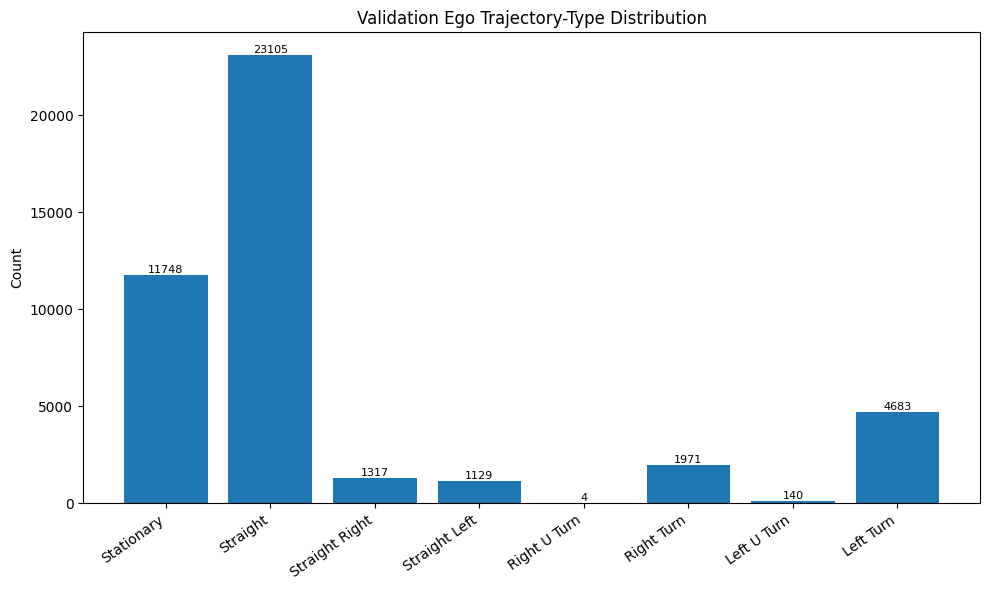

In [4]:
# 3. Build the bar chart
labels = [t.name.replace('_', ' ').title() for t in validation_counts]   # pretty labels
values = [validation_counts[t] for t in validation_counts]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values)

plt.ylabel("Count")
plt.title("Validation Ego Trajectory-Type Distribution")
plt.xticks(rotation=35, ha="right")

# optional: annotate exact counts on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, value,
             str(value), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

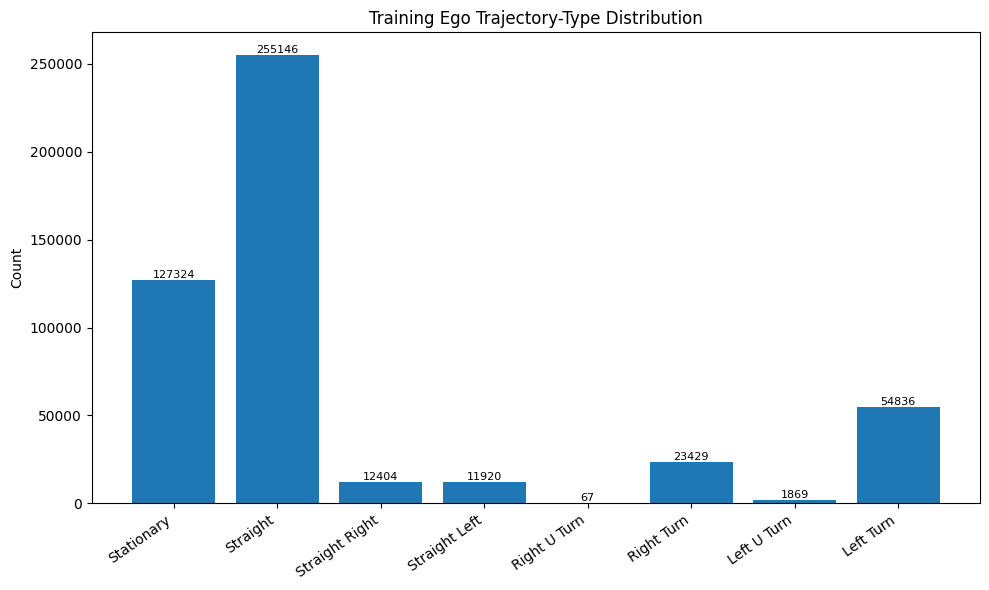

In [5]:
# 3. Build the bar chart
labels = [t.name.replace('_', ' ').title() for t in training_counts]   # pretty labels
values = [training_counts[t] for t in training_counts]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values)

plt.ylabel("Count")
plt.title("Training Ego Trajectory-Type Distribution")
plt.xticks(rotation=35, ha="right")

# optional: annotate exact counts on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, value,
             str(value), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

## find out mean and std of each action label

In [1]:
import numpy as np
import pickle
from glob import glob

In [2]:
with open('/robin-west/womd_processed/vbd/training/action_labels/action_labels_with_normalized_action_bucket_0.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
list(data.keys())[0]

'339ff3d43222b4e5'

In [17]:
data['339ff3d43222b4e5']

{'sdc_id': 8,
 'action_label': 2,
 'normalized_action': array([[[[ 0.19648385, -0.186704  ],
          [ 0.18664813, -0.20502726],
          [ 0.12271953, -0.22274971],
          [ 0.07360101, -0.22857666],
          [-0.07755232, -0.22489866],
          [-0.08660603, -0.21511396],
          [-0.22794771, -0.2044042 ],
          [ 0.11642051, -0.18822352],
          [ 0.93745536, -0.22035917],
          [ 1.37539506, -0.31164487],
          [ 1.38927937, -0.41975657],
          [ 1.28811693, -0.53308805],
          [ 1.18959951, -0.6156381 ],
          [ 1.36446953, -0.64797401],
          [ 1.53506279, -0.6836764 ],
          [ 1.72013187, -0.86510658]]]])}

In [9]:
data['339ff3d43222b4e5']['normalized_action'].squeeze().shape

(16, 2)

In [1]:
import matplotlib.pyplot as plt
from enum import IntEnum
import numpy as np
import pickle
from glob import glob

# 1. Enumerate trajectory classes
class TrajectoryType(IntEnum):
    STATIONARY      = 0
    STRAIGHT        = 1
    STRAIGHT_RIGHT  = 2
    STRAIGHT_LEFT   = 3
    RIGHT_U_TURN    = 4
    RIGHT_TURN      = 5
    LEFT_U_TURN     = 6
    LEFT_TURN       = 7

# 2. Counts for each class (ID : total)
validation_counts = {
    TrajectoryType.STATIONARY:     11748,
    TrajectoryType.STRAIGHT:       23105,
    TrajectoryType.STRAIGHT_RIGHT: 1317,
    TrajectoryType.STRAIGHT_LEFT:  1129,
    TrajectoryType.RIGHT_U_TURN:   4,
    TrajectoryType.RIGHT_TURN:     1971,
    TrajectoryType.LEFT_U_TURN:    140,
    TrajectoryType.LEFT_TURN:      4683,
}

training_counts = {
    TrajectoryType.STATIONARY:     127324,
    TrajectoryType.STRAIGHT:       255146,
    TrajectoryType.STRAIGHT_RIGHT: 12404,
    TrajectoryType.STRAIGHT_LEFT:  11920,
    TrajectoryType.RIGHT_U_TURN:   67,
    TrajectoryType.RIGHT_TURN:     23429,
    TrajectoryType.LEFT_U_TURN:    1869,
    TrajectoryType.LEFT_TURN:      54836,
}

In [2]:
data_dir = "/robin-west/womd_processed/vbd/training/action_labels/action_labels_with_normalized_action_bucket_*.pkl"
data_file_list = glob(data_dir)

In [3]:
import tqdm

In [4]:
action_count = {k:0 for k in TrajectoryType}
action_sum = {k:[] for k in TrajectoryType}

for data_path in tqdm.tqdm(data_file_list):
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    for sid in data.keys():
        action_count[data[sid]['action_label']] += 1
        action_sum[data[sid]['action_label']].append(data[sid]['normalized_action'].squeeze())


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


In [5]:
means = []
stds = []
for key in range(8):
    action_list = action_sum[key]
    actions = np.stack(action_list, axis=0)
    mean = np.mean(actions, axis=0)
    std = np.std(actions, axis=0)
    means.append(mean)
    stds.append(std)


In [6]:
means = np.asarray(means)
stds = np.asarray(stds)

In [7]:
means.shape

(8, 40, 2)

In [8]:
emprical_priors = {
    'means': means,
    'stds': stds,
}

emprical_priors_path = '/robin-west/womd_processed/vbd/training/emprical_priors.pkl'

with open(emprical_priors_path, 'wb') as emprical_priors_f:
    pickle.dump(emprical_priors, emprical_priors_f)